# Economic Complexity Analysis for Indonesia

**Implementation of Stojkoski & Hidalgo (2025)**: "Optimizing Economic Complexity"

This notebook uses **real Harvard Atlas trade data** with pre-calculated complexity metrics.

## Data Source:
- **Harvard Atlas of Economic Complexity** (HS92 classification)
- Country-product level data with pre-calculated ECI, PCI, RCA, COG, and distance

## Key Features:
- ✅ Uses real multi-country trade data (not simulated)
- ✅ Leverages pre-calculated RCA, PCI, COG from Harvard Atlas
- ✅ Proper ECI calculation using Method of Reflections
- ✅ Strategic diversification analysis for Indonesia

## Data Files Required (in `D:/download/hs_data/`):
- `hs92_country_product_year_4.csv` - Main country-product trade data
- `product_hs92.csv` - Product metadata and names
- `umap_layout_hs92.csv` - UMAP coordinates for visualization
- `top_edges_hs92.csv` - Product Space network edges

## Setup & Configuration

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Configuration
#DATA_DIR = '/Users/nadira/Documents/Work/cottonborry/data/'      # Path to your data files
DATA_DIR = 'D:/download/hs_data/'      # Path to your data files
OUTPUT_DIR = './output/'     # Where to save results
ANALYSIS_YEAR = 2023       # Year to analyze
INDONESIA_CODE = 'IDN'     # Country code

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✓ Output directory: {os.path.abspath(OUTPUT_DIR)}")

✓ Output directory: d:\newrepo\cottonborry\output


## 1. Data Loading

In [3]:
print("Loading datasets...\n")

# Main country-product trade data (includes all countries, products, years with RCA, PCI, COG)
df_trade = pd.read_csv(f'{DATA_DIR}hs92_country_product_year_4.csv')
print(f"✓ Country-Product Trade data: {df_trade.shape}")
print(f"  Columns: {list(df_trade.columns)}")

# Product metadata
df_products = pd.read_csv(f'{DATA_DIR}product_hs92.csv')
print(f"✓ Product Metadata: {df_products.shape}")

# UMAP layout for visualization
df_umap = pd.read_csv(f'{DATA_DIR}umap_layout_hs92.csv')
print(f"✓ UMAP Layout data: {df_umap.shape}")

# Product Space edges
df_edges = pd.read_csv(f'{DATA_DIR}top_edges_hs92.csv')
print(f"✓ Product Edges data: {df_edges.shape}")

# Check available years and countries
print(f"\n📊 Data Overview:")
print(f"  • Years available: {df_trade['year'].min()} - {df_trade['year'].max()}")
print(f"  • Number of countries: {df_trade['country_iso3_code'].nunique()}")
print(f"  • Number of products: {df_trade['product_hs92_code'].nunique()}")

print("\n✅ All datasets loaded successfully!")

Loading datasets...

✓ Country-Product Trade data: (6497429, 12)
  Columns: ['country_id', 'country_iso3_code', 'product_id', 'product_hs92_code', 'year', 'export_value', 'import_value', 'global_market_share', 'export_rca', 'distance', 'cog', 'pci']
✓ Product Metadata: (6390, 10)
✓ UMAP Layout data: (865, 4)
✓ Product Edges data: (4316, 2)

📊 Data Overview:
  • Years available: 1995 - 2023
  • Number of countries: 242
  • Number of products: 2485

✅ All datasets loaded successfully!


## 2. Data Preprocessing for Indonesia

In [4]:
print(f"Filtering data for year: {ANALYSIS_YEAR}")

# Filter trade data for analysis year
df_year = df_trade[df_trade['year'] == ANALYSIS_YEAR].copy()
print(f"✓ Data for {ANALYSIS_YEAR}: {len(df_year):,} country-product pairs")

# Get Indonesia specific data
df_indonesia = df_year[df_year['country_iso3_code'] == INDONESIA_CODE].copy()
print(f"✓ Indonesia data: {len(df_indonesia)} products")

# Merge product names
df_indonesia = df_indonesia.merge(
    df_products[['product_hs92_code', 'product_name_short', 'product_name']], 
    on='product_hs92_code', 
    how='left'
)

print(f"\n📊 Indonesia Trade Summary ({ANALYSIS_YEAR}):")
print(f"  • Total products traded: {len(df_indonesia)}")
print(f"  • Total exports: ${df_indonesia['export_value'].sum():,.0f}")
print(f"  • Total imports: ${df_indonesia['import_value'].sum():,.0f}")
print(f"  • Trade balance: ${(df_indonesia['export_value'].sum() - df_indonesia['import_value'].sum()):,.0f}")

# Check countries in the dataset
print(f"\n🌍 Countries in {ANALYSIS_YEAR} data: {df_year['country_iso3_code'].nunique()}")

Filtering data for year: 2023
✓ Data for 2023: 228,967 country-product pairs
✓ Indonesia data: 1212 products

📊 Indonesia Trade Summary (2023):
  • Total products traded: 1212
  • Total exports: $253,349,308,484
  • Total imports: $205,765,435,201
  • Trade balance: $47,583,873,283

🌍 Countries in 2023 data: 235


## 3. Calculate RCA (Revealed Comparative Advantage)

In [5]:
# Use pre-calculated RCA from Harvard Atlas data
# The dataset already contains 'export_rca' column

# Binary export basket: RCA >= 1 means comparative advantage
df_indonesia['has_rca'] = (df_indonesia['export_rca'] >= 1).astype(int)

print(f"📊 RCA Analysis Results (using pre-calculated values):")
print(f"  • Products with RCA >= 1: {df_indonesia['has_rca'].sum()}")
print(f"  • Products with RCA < 1: {(df_indonesia['has_rca'] == 0).sum()}")
print(f"  • Average RCA: {df_indonesia['export_rca'].mean():.3f}")
print(f"  • Max RCA: {df_indonesia['export_rca'].max():.3f}")

# Show top 10 products by RCA
print("\n🏆 Top 10 Products by RCA (Revealed Comparative Advantage):")
top_rca = df_indonesia.nlargest(10, 'export_rca')[
    ['product_hs92_code', 'product_name_short', 'export_value', 'export_rca', 'pci']
].copy()
top_rca['export_value'] = top_rca['export_value'].apply(lambda x: f"${x:,.0f}")
display(top_rca)

# Also show products with highest PCI that Indonesia exports
print("\n🧠 Top 10 Most Complex Products Indonesia Exports (RCA >= 1):")
top_complex = df_indonesia[df_indonesia['has_rca'] == 1].nlargest(10, 'pci')[
    ['product_hs92_code', 'product_name_short', 'export_value', 'export_rca', 'pci']
].copy()
top_complex['export_value'] = top_complex['export_value'].apply(lambda x: f"${x:,.0f}")
display(top_complex)

📊 RCA Analysis Results (using pre-calculated values):
  • Products with RCA >= 1: 225
  • Products with RCA < 1: 987
  • Average RCA: 1.243
  • Max RCA: 75.030

🏆 Top 10 Products by RCA (Revealed Comparative Advantage):


,product_hs92_code,product_name_short,export_value,export_rca,pci
246,2702,Lignite,"$7,721,021,272",75.030182,-1.475
32,0410,"Edible animal products, n.e.c.","$621,198,414",49.648224,0.946
866,7501,Nickel mattes,"$6,625,696,328",43.939236,-1.756
811,7218,Stainless steel in ingots,"$2,665,189,148",43.720562,1.205
128,1511,Palm oil,"$21,740,433,933",41.720264,-1.893
139,1522,Degras and wax residues,"$221,555,936",40.924007,-0.068
102,1203,Copra,"$33,305,414",31.769703,-1.753
117,1404,Vegetable products n.e.c.,"$579,526,571",30.701469,-2.013
136,1519,Stearic acid,"$4,468,427,246",30.336504,-0.976
130,1513,Coconut & palm kernel oil,"$1,974,385,913",28.378319,-1.228



🧠 Top 10 Most Complex Products Indonesia Exports (RCA >= 1):


,product_hs92_code,product_name_short,export_value,export_rca,pci
1162,9205,"Musical instruments, wind","$64,600,384",6.140079,1.853
751,6909,Ceramic wares for technical ware,"$100,499,211",1.164218,1.633
1069,8543,Electrical machines with individual functions ...,"$1,811,665,621",2.393802,1.430
536,4806,Transparent paper,"$31,270,995",1.259443,1.257
1059,8533,Electrical resistors,"$137,993,468",1.213097,1.235
811,7218,Stainless steel in ingots,"$2,665,189,148",43.720562,1.205
423,3812,Stabilizers for rubber or plastic,"$90,495,671",1.580236,1.204
336,2927,"Diazo-, azo-, or azoxy-compounds","$67,812,749",9.097953,1.197
531,4801,Newsprint,"$85,930,363",1.013348,1.146
312,2903,Halogenated derivatives of hydrocarbons,"$153,368,082",1.210834,1.107


## 4. Create Country-Product Matrix (Real Data)

Building binary M_cp matrix where M_cp = 1 if country c has RCA >= 1 in product p.

In [6]:
# Build Country-Product Matrix from real trade data
print("Building Country-Product Matrix from real trade data...")

# Get all unique countries and products for the analysis year
countries = df_year['country_iso3_code'].unique()
products = df_year['product_hs92_code'].unique()

print(f"  • Countries: {len(countries)}")
print(f"  • Products: {len(products)}")

# Create binary RCA matrix (M_cp = 1 if RCA >= 1)
# Pivot the data to create country x product matrix
df_pivot = df_year.pivot_table(
    index='country_iso3_code',
    columns='product_hs92_code',
    values='export_rca',
    fill_value=0
)

# Binarize: 1 if RCA >= 1, else 0
M = (df_pivot >= 1).astype(int)

print(f"\n📊 Country-Product Matrix (Binary RCA):")
print(f"  • Shape: {M.shape[0]} countries × {M.shape[1]} products")
print(f"  • Total RCA >= 1 entries: {M.sum().sum():,}")
print(f"  • Matrix density: {(M.sum().sum() / (M.shape[0] * M.shape[1])) * 100:.2f}%")

# Indonesia's export basket
indonesia_basket = M.loc[INDONESIA_CODE] if INDONESIA_CODE in M.index else pd.Series(0, index=M.columns)
print(f"\n🇮🇩 Indonesia's Export Basket:")
print(f"  • Products with RCA >= 1: {indonesia_basket.sum()}")
print(f"  • Share of all products: {indonesia_basket.sum() / len(M.columns) * 100:.1f}%")

# Create a lookup dictionary for product names
product_name_lookup = df_products.set_index('product_hs92_code')['product_name_short'].to_dict()

# Show sample of Indonesia's top exports with names
idn_exports = indonesia_basket[indonesia_basket == 1].index.tolist()[:10]
print(f"\n📦 Sample of Indonesia's Exports (RCA >= 1):")
for hs_code in idn_exports:
    name = product_name_lookup.get(hs_code, 'Unknown')
    print(f"   • {hs_code}: {name}")

Building Country-Product Matrix from real trade data...
  • Countries: 235
  • Products: 2434

📊 Country-Product Matrix (Binary RCA):
  • Shape: 234 countries × 2433 products
  • Total RCA >= 1 entries: 30,114
  • Matrix density: 5.29%

🇮🇩 Indonesia's Export Basket:
  • Products with RCA >= 1: 225
  • Share of all products: 9.2%

📦 Sample of Indonesia's Exports (RCA >= 1):
   • 0208: Other meat
   • 0301: Live Fish
   • 0303: Frozen fish, excluding fillets
   • 0304: Fish fillets
   • 0305: Preserved fish
   • 0306: Crustaceans
   • 0307: Molluscs
   • 0410: Edible animal products, n.e.c.
   • 0508: Coral and shells
   • 0801: Cashew nuts & coconuts


## 5. Calculate ECI and PCI (Method of Reflections)

In [7]:
def calculate_eci_pci(M, n_iterations=20):
    """
    Calculate Economic Complexity Index (ECI) and Product Complexity Index (PCI)
    using the Method of Reflections (Hidalgo & Hausmann, 2009)
    
    Parameters:
    -----------
    M : pd.DataFrame
        Binary country-product matrix (M_cp = 1 if RCA >= 1)
    n_iterations : int
        Number of iterations for Method of Reflections
    
    Returns:
    --------
    ECI : pd.Series - Economic Complexity Index by country
    PCI : pd.Series - Product Complexity Index by product
    """
    # Diversity: number of products each country exports with RCA >= 1
    diversity = M.sum(axis=1)
    
    # Ubiquity: number of countries that export each product with RCA >= 1
    ubiquity = M.sum(axis=0)
    
    # Initialize complexity measures
    kc = diversity.astype(float).copy()
    kp = ubiquity.astype(float).copy()
    
    # Method of Reflections iterations
    for iteration in range(n_iterations):
        # Country complexity = average complexity of products it exports
        kc_new = M.dot(kp) / diversity.replace(0, np.nan)
        kc_new = kc_new.fillna(0)
        
        # Product complexity = average complexity of countries that export it
        kp_new = M.T.dot(kc) / ubiquity.replace(0, np.nan)
        kp_new = kp_new.fillna(0)
        
        kc = kc_new
        kp = kp_new
    
    # Standardize to mean=0, std=1
    ECI = (kc - kc.mean()) / kc.std()
    PCI = (kp - kp.mean()) / kp.std()
    
    return ECI, PCI

print("Calculating ECI and PCI using Method of Reflections...")
ECI, PCI = calculate_eci_pci(M, n_iterations=20)

print("\n✅ Calculation complete!")
print(f"\n🇮🇩 Indonesia's ECI: {ECI[INDONESIA_CODE]:.3f}")
print(f"   Indonesia's ECI Rank: {(ECI > ECI[INDONESIA_CODE]).sum() + 1} / {len(ECI)}")

print(f"\n🏆 Top 10 Most Complex Economies:")
for i, (country, eci) in enumerate(ECI.nlargest(10).items(), 1):
    marker = " ← Indonesia" if country == INDONESIA_CODE else ""
    print(f"   {i:2}. {country}: {eci:.3f}{marker}")

print(f"\n📉 Bottom 5 Economies by ECI:")
for i, (country, eci) in enumerate(ECI.nsmallest(5).items(), 1):
    print(f"   {i:2}. {country}: {eci:.3f}")

print(f"\n🧠 Top 10 Most Complex Products (by PCI):")
for i, (product, pci) in enumerate(PCI.nlargest(10).items(), 1):
    name = product_name_lookup.get(product, 'Unknown')
    print(f"   {i:2}. {product}: {name} (PCI={pci:.3f})")

print(f"\n📦 Least Complex Products (by PCI):")
for i, (product, pci) in enumerate(PCI.nsmallest(5).items(), 1):
    name = product_name_lookup.get(product, 'Unknown')
    print(f"   {i:2}. {product}: {name} (PCI={pci:.3f})")

Calculating ECI and PCI using Method of Reflections...

✅ Calculation complete!

🇮🇩 Indonesia's ECI: 0.272
   Indonesia's ECI Rank: 156 / 234

🏆 Top 10 Most Complex Economies:
    1. LAO: 0.282
    2. TCD: 0.282
    3. TKL: 0.282
    4. BGD: 0.281
    5. NER: 0.281
    6. IRQ: 0.281
    7. BTN: 0.281
    8. BVT: 0.281
    9. COG: 0.281
   10. HMD: 0.281

📉 Bottom 5 Economies by ECI:
    1. SXM: -3.939
    2. PLW: -3.905
    3. SMR: -3.905
    4. STP: -3.889
    5. ABW: -3.875

🧠 Top 10 Most Complex Products (by PCI):
    1. 5102: Animal hair (PCI=0.936)
    2. 2610: Chromium ore (PCI=0.936)
    3. 5205: Cotton yarn of > 85% (PCI=0.936)
    4. 9615: Combs, hair-slides etc. (PCI=0.936)
    5. 6108: Women's undergarments, knit (PCI=0.935)
    6. 2524: Asbestos (PCI=0.935)
    7. 4501: Natural cork, raw (PCI=0.935)
    8. 0703: Onions, shallots, garlic (PCI=0.935)
    9. 2510: Natural calcium phosphates (PCI=0.935)
   10. 1208: Flours of oil seeds (PCI=0.935)

📦 Least Complex Products (by 

## 6. Calculate Product Proximity Matrix

In [8]:
def calculate_proximity(M):
    """
    Calculate product proximity (relatedness) matrix using conditional probability.
    
    φ_pp' = min(P(RCA_p>=1 | RCA_p'>=1), P(RCA_p'>=1 | RCA_p>=1))
    
    Parameters:
    -----------
    M : pd.DataFrame
        Binary country-product matrix
    
    Returns:
    --------
    proximity : pd.DataFrame - Proximity matrix (products x products)
    """
    M_arr = M.values
    products = M.columns
    
    # Ubiquity for each product
    ubiquity = M_arr.sum(axis=0)
    
    # Co-occurrence matrix (number of countries exporting both products)
    cooccurrence = M_arr.T @ M_arr
    
    # Conditional probabilities
    # P(p|p') = cooccurrence[p,p'] / ubiquity[p']
    with np.errstate(divide='ignore', invalid='ignore'):
        cond_prob_1 = cooccurrence / ubiquity.reshape(1, -1)  # P(p|p')
        cond_prob_2 = cooccurrence / ubiquity.reshape(-1, 1)  # P(p'|p)
        
        # Proximity = minimum of conditional probabilities
        prox = np.minimum(cond_prob_1, cond_prob_2)
        prox = np.nan_to_num(prox, nan=0.0, posinf=0.0, neginf=0.0)
    
    proximity = pd.DataFrame(prox, index=products, columns=products)
    
    return proximity

print("Calculating product proximity matrix...")
proximity = calculate_proximity(M)

print(f"\n✅ Proximity matrix calculated: {proximity.shape}")
print(f"  • Average proximity (non-zero): {proximity.values[proximity.values > 0].mean():.3f}")
print(f"  • Max proximity: {proximity.values.max():.3f}")
print(f"  • Median proximity (non-zero): {np.median(proximity.values[proximity.values > 0]):.3f}")

Calculating product proximity matrix...

✅ Proximity matrix calculated: (2433, 2433)
  • Average proximity (non-zero): 0.186
  • Max proximity: 1.000
  • Median proximity (non-zero): 0.154


## 7. Calculate Density (Relatedness to Current Capabilities)

In [9]:
def calculate_density(proximity, M_country):
    """
    Calculate density (relatedness to current capabilities) for each product.
    
    Density_cp = Σ_p' (M_cp' × φ_pp') / Σ_p' φ_pp'
    
    Density measures how related a product is to a country's current export basket.
    Higher density = easier to develop comparative advantage.
    
    Parameters:
    -----------
    proximity : pd.DataFrame - Product proximity matrix
    M_country : pd.Series - Binary vector of country's current exports (1 if RCA >= 1)
    
    Returns:
    --------
    density : pd.Series - Density for each product
    """
    density = {}
    for product in proximity.columns:
        # Sum of proximity to products country currently exports
        numerator = (proximity.loc[product] * M_country).sum()
        denominator = proximity.loc[product].sum()
        
        if denominator > 0:
            density[product] = numerator / denominator
        else:
            density[product] = 0
    
    return pd.Series(density)

# Calculate density for Indonesia
print("Calculating density (relatedness) for Indonesia...")
density = calculate_density(proximity, indonesia_basket)

print(f"\n✅ Density calculated for all {len(density)} products")
print(f"  • Average density: {density.mean():.3f}")
print(f"  • Max density: {density.max():.3f}")

# Note: The Harvard Atlas data also has pre-calculated 'distance' column
# distance = 1 - density (inverse relationship)
print(f"\n💡 Note: Harvard Atlas 'distance' column = 1 - density")
print(f"  • We calculated density from proximity matrix for transparency")

Calculating density (relatedness) for Indonesia...

✅ Density calculated for all 2433 products
  • Average density: 0.091
  • Max density: 0.461

💡 Note: Harvard Atlas 'distance' column = 1 - density
  • We calculated density from proximity matrix for transparency


## 8. Strategic Diversification Analysis (Using Harvard Atlas Pre-calculated Metrics)

**Using pre-calculated Harvard Atlas metrics for strategic analysis:**
- **PCI** - Product Complexity Index (from full global trade data)
- **COG** - Complexity Outlook Gain (strategic value of acquiring product)
- **Distance** - Inverse of density (1 - density), measures effort needed

**Stojkoski & Hidalgo (2025) Framework**:
- X-axis: Density = 1 - Distance (feasibility)
- Y-axis: PCI (desirability - product complexity)
- Optimal targets: High PCI + Low Distance (high density)

📊 Using Harvard Atlas Pre-calculated Metrics for Strategic Analysis
   (These are based on complete global trade data)

✅ Indonesia product data: 1212 products
   • Pre-calculated PCI range: -2.613 to 3.472
   • Pre-calculated Distance range: 0.457 to 0.890
   • Pre-calculated COG range: -0.361 to 1.594

🇮🇩 Indonesia Export Analysis:
   • Current exports (RCA >= 1): 225
   • Export opportunities (RCA < 1): 986


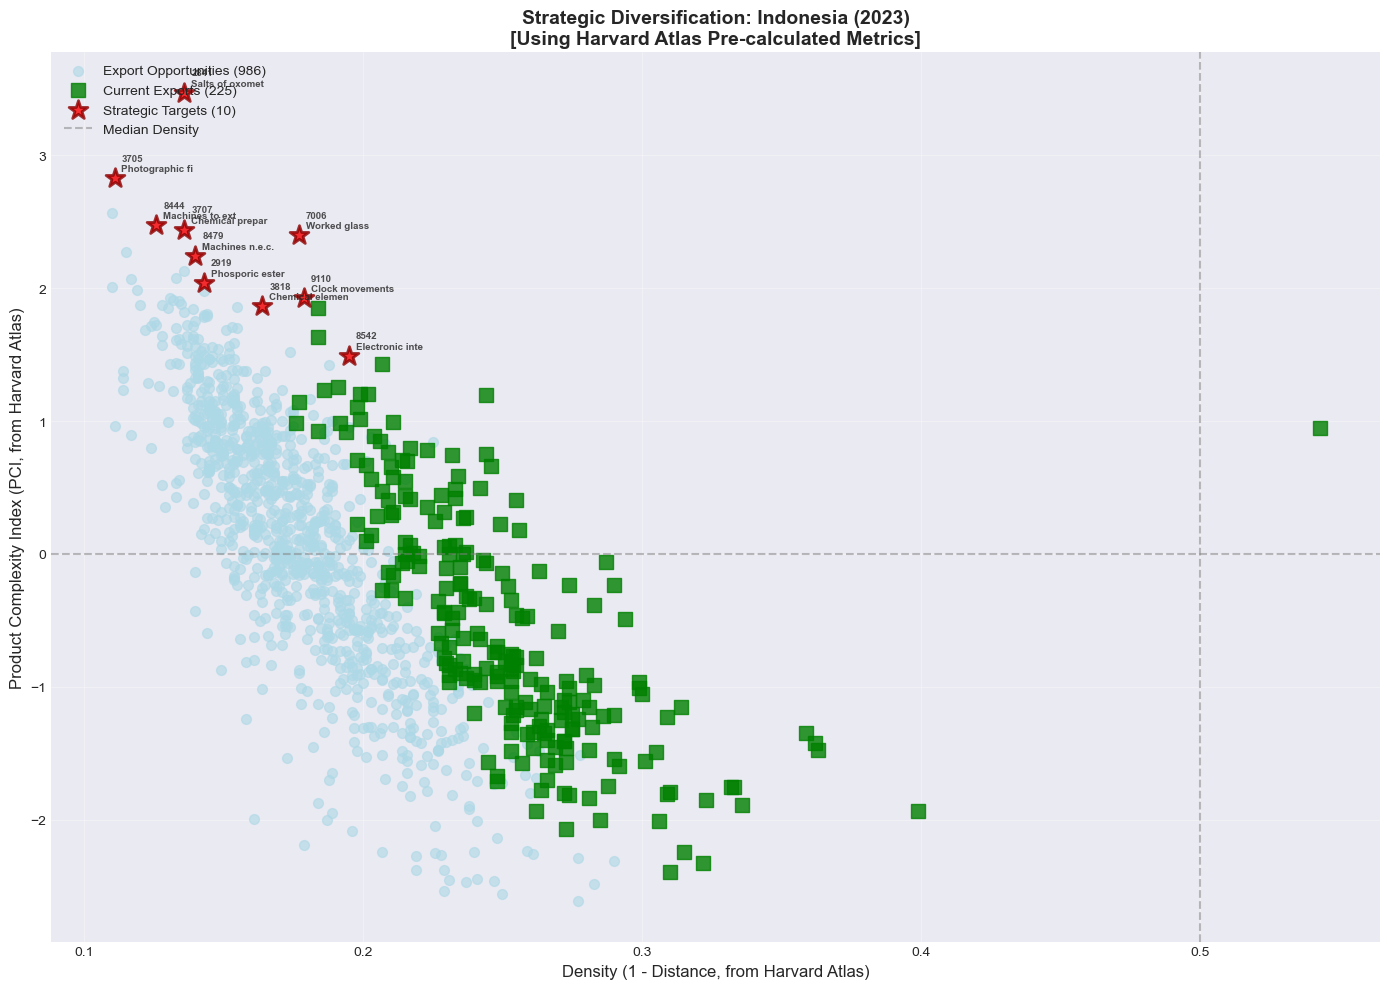


✅ Visualization saved: ./output/relatedness_complexity_indonesia.png

🎯 Top Strategic Opportunities (Harvard Atlas metrics):
    1. 2841: Salts of oxometallic acids
       PCI=3.472, Density=0.136, COG=0.002
    2. 7006: Worked glass
       PCI=2.398, Density=0.177, COG=0.979
    3. 9110: Clock movements, complete, unassembled
       PCI=1.926, Density=0.179, COG=0.740
    4. 3707: Chemical preparations for photographic uses
       PCI=2.441, Density=0.136, COG=0.804
    5. 8479: Machines n.e.c.
       PCI=2.244, Density=0.140, COG=1.429
    6. 3705: Photographic film, developed
       PCI=2.826, Density=0.111, COG=0.956
    7. 8444: Machines to extrude, cut manmade textile fibres
       PCI=2.473, Density=0.126, COG=1.111
    8. 3818: Chemical elements for electronics
       PCI=1.865, Density=0.164, COG=1.155
    9. 2919: Phosporic esters
       PCI=2.042, Density=0.143, COG=1.221
   10. 8542: Electronic integrated circuits
       PCI=1.491, Density=0.195, COG=0.958


In [10]:
# Strategic Analysis using Harvard Atlas pre-calculated metrics
# These are calculated on FULL global trade data, not our local calculations

print("📊 Using Harvard Atlas Pre-calculated Metrics for Strategic Analysis")
print("   (These are based on complete global trade data)\n")

# Get Indonesia's data with pre-calculated metrics
df_idn_strategic = df_indonesia.copy()

# Calculate density from distance (density = 1 - distance)
df_idn_strategic['density'] = 1 - df_idn_strategic['distance']

# Add product names
df_idn_strategic = df_idn_strategic.merge(
    df_products[['product_hs92_code', 'product_name_short']], 
    on='product_hs92_code', 
    how='left',
    suffixes=('', '_dup')
)

print(f"✅ Indonesia product data: {len(df_idn_strategic)} products")
print(f"   • Pre-calculated PCI range: {df_idn_strategic['pci'].min():.3f} to {df_idn_strategic['pci'].max():.3f}")
print(f"   • Pre-calculated Distance range: {df_idn_strategic['distance'].min():.3f} to {df_idn_strategic['distance'].max():.3f}")
print(f"   • Pre-calculated COG range: {df_idn_strategic['cog'].min():.3f} to {df_idn_strategic['cog'].max():.3f}")

# Split into current exports (RCA >= 1) and opportunities (RCA < 1)
current_exports = df_idn_strategic[df_idn_strategic['export_rca'] >= 1].copy()
export_opportunities = df_idn_strategic[df_idn_strategic['export_rca'] < 1].copy()

print(f"\n🇮🇩 Indonesia Export Analysis:")
print(f"   • Current exports (RCA >= 1): {len(current_exports)}")
print(f"   • Export opportunities (RCA < 1): {len(export_opportunities)}")

# Create Relatedness-Complexity diagram
fig, ax = plt.subplots(figsize=(14, 10))

# Plot opportunities
ax.scatter(export_opportunities['density'], export_opportunities['pci'], 
           c='lightblue', s=50, alpha=0.6, label=f'Export Opportunities ({len(export_opportunities)})')

# Plot current exports
ax.scatter(current_exports['density'], current_exports['pci'], 
           c='green', s=100, alpha=0.8, marker='s', label=f'Current Exports ({len(current_exports)})')

# Identify top strategic opportunities using Harvard's pre-calculated metrics
# Score = PCI × density (or PCI / distance, or use COG directly)
export_opportunities['strategic_score'] = export_opportunities['pci'] * export_opportunities['density']

# Filter for products with positive complexity and reasonable feasibility
strategic_opps = export_opportunities[
    (export_opportunities['pci'] > 0) & 
    (export_opportunities['density'] > 0.1)
].copy()

if len(strategic_opps) < 10:
    strategic_opps = export_opportunities.nlargest(10, 'strategic_score')
else:
    strategic_opps = strategic_opps.nlargest(10, 'strategic_score')

top_opportunities = strategic_opps

# Highlight top opportunities
ax.scatter(top_opportunities['density'], top_opportunities['pci'],
           c='red', s=200, alpha=0.8, marker='*', 
           label=f'Strategic Targets ({len(top_opportunities)})', 
           edgecolors='darkred', linewidths=2)

# Add labels for top opportunities (HS code + short name)
for _, row in top_opportunities.iterrows():
    name = row.get('product_name_short', '')
    short_name = str(name)[:15] if pd.notna(name) else ''
    label_text = f"{row['product_hs92_code']}\n{short_name}"
    ax.annotate(label_text, 
                (row['density'], row['pci']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=7, fontweight='bold', alpha=0.8)

# Add quadrant lines
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Median Density')

ax.set_xlabel('Density (1 - Distance, from Harvard Atlas)', fontsize=12)
ax.set_ylabel('Product Complexity Index (PCI, from Harvard Atlas)', fontsize=12)
ax.set_title(f'Strategic Diversification: Indonesia ({ANALYSIS_YEAR})\n[Using Harvard Atlas Pre-calculated Metrics]', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = os.path.join(OUTPUT_DIR, 'relatedness_complexity_indonesia.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Visualization saved: {output_file}")

# Print top opportunities with product names
print(f"\n🎯 Top Strategic Opportunities (Harvard Atlas metrics):")
for i, (_, row) in enumerate(top_opportunities.iterrows(), 1):
    name = row.get('product_name_short', 'Unknown')
    print(f"   {i:2}. {row['product_hs92_code']}: {name}")
    print(f"       PCI={row['pci']:.3f}, Density={row['density']:.3f}, COG={row['cog']:.3f}")

## 9. Product Space Network Visualization

Building Product Space Network using Harvard Atlas edge data...
✓ Edge file columns: ['product_hs92_code_source', 'product_hs92_code_target']
✓ Using 4316 pre-calculated product edges
  • Nodes: 865, Edges: 2158
✓ UMAP file columns: ['product_hs92_code', 'product_space_x', 'product_space_y', 'product_space_cluster_name']
✓ Using UMAP layout from Harvard Atlas


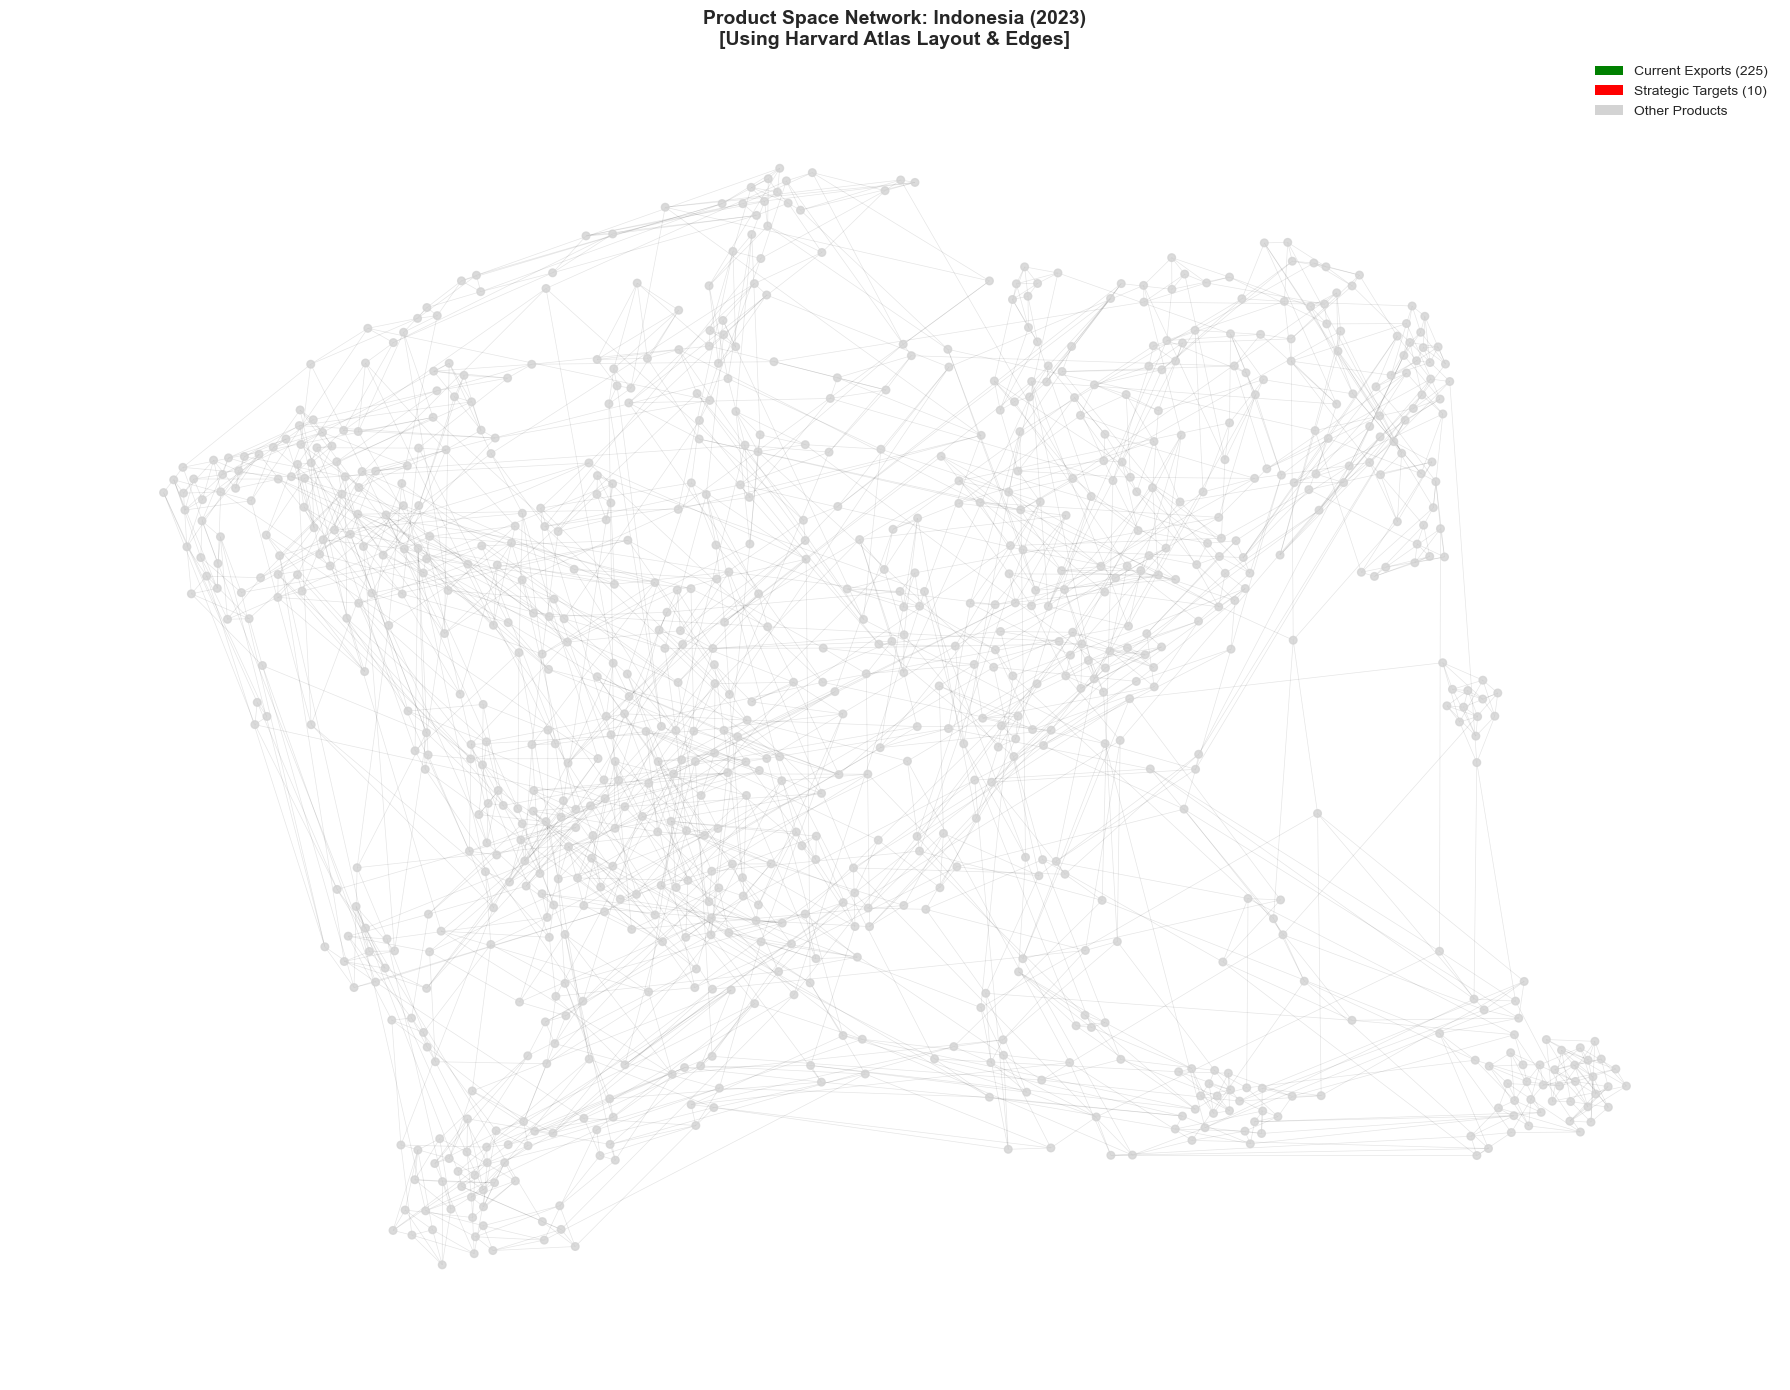


✅ Network visualization saved: ./output/product_space_network_indonesia.png

🎯 Strategic Targets (highlighted in red):
    1. 2841: Salts of oxometallic acids
    2. 7006: Worked glass
    3. 9110: Clock movements, complete, unassembled
    4. 3707: Chemical preparations for photographic uses
    5. 8479: Machines n.e.c.
    6. 3705: Photographic film, developed
    7. 8444: Machines to extrude, cut manmade textile fibres
    8. 3818: Chemical elements for electronics
    9. 2919: Phosporic esters
   10. 8542: Electronic integrated circuits


In [ ]:
# Product Space Network using Harvard Atlas pre-calculated data
print("Building Product Space Network using Harvard Atlas edge data...")

# Check column names in edges file
print(f"✓ Edge file columns: {list(df_edges.columns)}")
print(f"✓ Using {len(df_edges)} pre-calculated product edges")

# Create network from Harvard Atlas edges
G = nx.Graph()

# Add edges from Harvard Atlas data (ensure consistent types - convert to string)
for _, row in df_edges.iterrows():
    source = str(row['product_hs92_code_source'])
    target = str(row['product_hs92_code_target'])
    G.add_edge(source, target)

print(f"  • Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

# Use UMAP layout from Harvard Atlas
print(f"✓ UMAP file columns: {list(df_umap.columns)}")

if len(df_umap) > 0:
    print("✓ Using UMAP layout from Harvard Atlas")
    pos = {}
    for _, row in df_umap.iterrows():
        pos[str(row['product_hs92_code'])] = (row['product_space_x'], row['product_space_y'])
else:
    print("  Using spring layout")
    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)

# Get Indonesia's current exports (RCA >= 1) - ensure string type
idn_exports_set = set(str(x) for x in current_exports['product_hs92_code'].tolist())
optimal_products_set = set(str(x) for x in top_opportunities['product_hs92_code'].tolist())

# Debug: Check overlap
nodes_in_graph = set(G.nodes())
idn_in_graph = idn_exports_set & nodes_in_graph
optimal_in_graph = optimal_products_set & nodes_in_graph

print(f"\n📊 Matching products in network:")
print(f"  • Indonesia exports in graph: {len(idn_in_graph)} / {len(idn_exports_set)}")
print(f"  • Strategic targets in graph: {len(optimal_in_graph)} / {len(optimal_products_set)}")

# Create figure with better styling
fig, ax = plt.subplots(figsize=(20, 16))

# Separate nodes by category for clearer visualization
nodes_current = [n for n in G.nodes() if n in idn_exports_set]
nodes_strategic = [n for n in G.nodes() if n in optimal_products_set and n not in idn_exports_set]
nodes_other = [n for n in G.nodes() if n not in idn_exports_set and n not in optimal_products_set]

# Draw edges first (light)
nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.3, edge_color='gray', ax=ax)

# Draw nodes by category (layered for visibility)
# Other products (background) - very small and light
if nodes_other:
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_other, 
                          node_color='lightgray', node_size=20, alpha=0.4, ax=ax)

# Current exports (green) - medium size
if nodes_current:
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_current,
                          node_color='green', node_size=120, alpha=0.8, ax=ax,
                          edgecolors='darkgreen', linewidths=0.5)

# Strategic targets (red) - large and prominent
if nodes_strategic:
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_strategic,
                          node_color='red', node_size=300, alpha=0.9, ax=ax,
                          edgecolors='darkred', linewidths=2)

# Label strategic targets with HS code + short name
labels = {}
for p in optimal_products_set:
    if p in G.nodes() and p in pos:
        name = product_name_lookup.get(int(p) if p.isdigit() else p, '')
        if not name:
            name = product_name_lookup.get(p, '')
        short_name = str(name)[:15] if name else ''
        labels[p] = f"{p}\n{short_name}"

if labels:
    # Draw labels with white background for readability
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold', 
                           font_color='darkred', ax=ax)

ax.set_title(f'Product Space Network: Indonesia ({ANALYSIS_YEAR})\n[Green = Current Exports ({len(nodes_current)}), Red = Strategic Targets ({len(nodes_strategic)})]',
            fontsize=16, fontweight='bold')
ax.axis('off')

# Better legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=12, 
           label=f'Current Exports ({len(nodes_current)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=15,
           markeredgecolor='darkred', markeredgewidth=2, label=f'Strategic Targets ({len(nodes_strategic)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=8,
           label=f'Other Products ({len(nodes_other)})')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.9)

plt.tight_layout()
output_file = os.path.join(OUTPUT_DIR, 'product_space_network_indonesia.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Network visualization saved: {output_file}")

# Print strategic targets with names
print(f"\n🎯 Strategic Targets (highlighted in RED):")
for i, (_, row) in enumerate(top_opportunities.iterrows(), 1):
    name = row.get('product_name_short', 'Unknown')
    print(f"   {i:2}. {row['product_hs92_code']}: {name}")

## 10. Strategic Recommendations

In [12]:
print("="*80)
print("STRATEGIC DIVERSIFICATION RECOMMENDATIONS FOR INDONESIA")
print("Based on Harvard Atlas Pre-calculated Metrics (Full Global Trade Data)")
print("="*80)

print(f"\n📊 Current Economic Position ({ANALYSIS_YEAR}):")
print(f"  • Indonesia's ECI (calculated): {ECI[INDONESIA_CODE]:.3f}")
print(f"  • ECI Global Rank: {(ECI > ECI[INDONESIA_CODE]).sum() + 1} / {len(ECI)}")
print(f"  • Current export diversity: {len(current_exports)} products (RCA >= 1)")
print(f"  • Average PCI of current exports: {current_exports['pci'].mean():.3f}")

# Build detailed recommendations using Harvard Atlas pre-calculated metrics
recommendations = top_opportunities[[
    'product_hs92_code', 'product_name_short', 'pci', 'density', 'cog', 'distance', 'strategic_score'
]].copy()
recommendations.columns = ['HS Code', 'Product Name', 'PCI', 'Density', 'COG', 'Distance', 'Score']
recommendations = recommendations.reset_index(drop=True)
recommendations.index = recommendations.index + 1

print(f"\n🎯 Top {len(recommendations)} Strategic Diversification Targets:")
print(f"   (Using Harvard Atlas pre-calculated PCI, Distance, and COG)\n")

display(recommendations)

print(f"\n💡 Key Insights (Harvard Atlas Metrics):")
avg_pci_targets = recommendations['PCI'].mean()
avg_pci_current = current_exports['pci'].mean()
avg_cog_targets = recommendations['COG'].mean()
avg_distance_targets = recommendations['Distance'].mean()

print(f"  • Average PCI of targets: {avg_pci_targets:.3f}")
print(f"  • Average PCI of current exports: {avg_pci_current:.3f}")
print(f"  • Complexity uplift potential: {avg_pci_targets - avg_pci_current:+.3f}")
print(f"  • Average COG (Complexity Outlook Gain): {avg_cog_targets:.3f}")
print(f"  • Average Distance (effort needed): {avg_distance_targets:.3f}")
print(f"  • Average Density (feasibility): {recommendations['Density'].mean():.3f}")

print(f"\n📈 Strategic Interpretation:")
print(f"  • These products are {recommendations['Density'].mean()*100:.0f}% connected to Indonesia's current capabilities")
print(f"  • Average effort (distance) to acquire: {avg_distance_targets:.2f}")
print(f"  • Acquiring these would add {len(recommendations)} higher-complexity products")
print(f"  • COG indicates future diversification potential from these products")

# Also show top products by COG (future strategic value)
print(f"\n🔮 Top 5 Products by Complexity Outlook Gain (COG):")
top_cog = export_opportunities.nlargest(5, 'cog')[
    ['product_hs92_code', 'product_name_short', 'pci', 'cog', 'distance']
]
for i, (_, row) in enumerate(top_cog.iterrows(), 1):
    name = row.get('product_name_short', 'Unknown')
    print(f"   {i}. {row['product_hs92_code']}: {name}")
    print(f"      PCI={row['pci']:.3f}, COG={row['cog']:.3f}, Distance={row['distance']:.3f}")

STRATEGIC DIVERSIFICATION RECOMMENDATIONS FOR INDONESIA
Based on Harvard Atlas Pre-calculated Metrics (Full Global Trade Data)

📊 Current Economic Position (2023):
  • Indonesia's ECI (calculated): 0.272
  • ECI Global Rank: 156 / 234
  • Current export diversity: 225 products (RCA >= 1)
  • Average PCI of current exports: -0.540

🎯 Top 10 Strategic Diversification Targets:
   (Using Harvard Atlas pre-calculated PCI, Distance, and COG)



,HS Code,Product Name,PCI,Density,COG,Distance,Score
1,2841,Salts of oxometallic acids,3.472,0.136,0.002,0.864,0.472192
2,7006,Worked glass,2.398,0.177,0.979,0.823,0.424446
3,9110,"Clock movements, complete, unassembled",1.926,0.179,0.740,0.821,0.344754
4,3707,Chemical preparations for photographic uses,2.441,0.136,0.804,0.864,0.331976
5,8479,Machines n.e.c.,2.244,0.140,1.429,0.860,0.314160
6,3705,"Photographic film, developed",2.826,0.111,0.956,0.889,0.313686
7,8444,"Machines to extrude, cut manmade textile fibres",2.473,0.126,1.111,0.874,0.311598
8,3818,Chemical elements for electronics,1.865,0.164,1.155,0.836,0.305860
9,2919,Phosporic esters,2.042,0.143,1.221,0.857,0.292006
10,8542,Electronic integrated circuits,1.491,0.195,0.958,0.805,0.290745



💡 Key Insights (Harvard Atlas Metrics):
  • Average PCI of targets: 2.318
  • Average PCI of current exports: -0.540
  • Complexity uplift potential: +2.858
  • Average COG (Complexity Outlook Gain): 0.935
  • Average Distance (effort needed): 0.849
  • Average Density (feasibility): 0.151

📈 Strategic Interpretation:
  • These products are 15% connected to Indonesia's current capabilities
  • Average effort (distance) to acquire: 0.85
  • Acquiring these would add 10 higher-complexity products
  • COG indicates future diversification potential from these products

🔮 Top 5 Products by Complexity Outlook Gain (COG):
   1. 7318: Screws and similar articles of iron or steel
      PCI=1.883, COG=1.594, Distance=0.865
   2. 8208: Knives and blades for machines
      PCI=1.572, COG=1.535, Distance=0.872
   3. 9027: Instruments for physical or chemical analysis
      PCI=1.744, COG=1.512, Distance=0.875
   4. 8514: Industrial electric furnaces
      PCI=1.495, COG=1.499, Distance=0.859
   5.

## 11. Export Results to CSV

In [13]:
print("Exporting results (using Harvard Atlas pre-calculated metrics)...\n")

# 1. Strategic recommendations
output_file = os.path.join(OUTPUT_DIR, 'strategic_recommendations.csv')
recommendations.to_csv(output_file)
print(f"✓ {output_file}")

# 2. All products with Harvard Atlas metrics for Indonesia
all_products_analysis = df_idn_strategic[[
    'product_hs92_code', 'product_name_short', 'export_value', 'import_value',
    'export_rca', 'pci', 'cog', 'distance', 'density'
]].copy()
all_products_analysis['is_current_export'] = (all_products_analysis['export_rca'] >= 1).astype(int)
all_products_analysis['strategic_score'] = all_products_analysis.apply(
    lambda row: row['pci'] * row['density'] if row['is_current_export'] == 0 else 0, axis=1
)
all_products_analysis = all_products_analysis.sort_values('strategic_score', ascending=False)
output_file = os.path.join(OUTPUT_DIR, 'all_products_analysis.csv')
all_products_analysis.to_csv(output_file, index=False)
print(f"✓ {output_file}")

# 3. ECI rankings for all countries (our calculation)
eci_rankings = pd.DataFrame({'country': ECI.index, 'eci': ECI.values})
eci_rankings = eci_rankings.sort_values('eci', ascending=False).reset_index(drop=True)
eci_rankings['rank'] = eci_rankings.index + 1
eci_rankings = eci_rankings[['rank', 'country', 'eci']]
output_file = os.path.join(OUTPUT_DIR, 'eci_rankings.csv')
eci_rankings.to_csv(output_file, index=False)
print(f"✓ {output_file}")

# 4. PCI rankings (Harvard Atlas pre-calculated)
# Get unique products with their PCI from the year data
pci_rankings = df_year[['product_hs92_code', 'pci']].drop_duplicates()
pci_rankings = pci_rankings.merge(
    df_products[['product_hs92_code', 'product_name_short']], 
    on='product_hs92_code',
    how='left'
)
pci_rankings = pci_rankings.sort_values('pci', ascending=False).reset_index(drop=True)
pci_rankings['rank'] = pci_rankings.index + 1
pci_rankings = pci_rankings[['rank', 'product_hs92_code', 'product_name_short', 'pci']]
output_file = os.path.join(OUTPUT_DIR, 'pci_rankings.csv')
pci_rankings.to_csv(output_file, index=False)
print(f"✓ {output_file}")

# 5. Indonesia current exports
current_exports_output = current_exports[[
    'product_hs92_code', 'product_name_short', 'export_value', 'export_rca', 'pci', 'cog'
]].sort_values('export_value', ascending=False)
output_file = os.path.join(OUTPUT_DIR, 'indonesia_current_exports.csv')
current_exports_output.to_csv(output_file, index=False)
print(f"✓ {output_file}")

print("\n" + "="*80)
print("✅ Analysis Complete! All results exported to:", os.path.abspath(OUTPUT_DIR))
print("="*80)

# Summary
print(f"\n📁 Output Files:")
print(f"  • strategic_recommendations.csv - Top diversification targets (Harvard Atlas metrics)")
print(f"  • all_products_analysis.csv - Full product analysis for Indonesia")
print(f"  • eci_rankings.csv - Country ECI rankings (Method of Reflections)")
print(f"  • pci_rankings.csv - Product complexity rankings (Harvard Atlas)")
print(f"  • indonesia_current_exports.csv - Indonesia's current export basket")
print(f"  • relatedness_complexity_indonesia.png - Strategic visualization")
print(f"  • product_space_network_indonesia.png - Product Space network")

print(f"\n📌 Note: Strategic analysis uses Harvard Atlas pre-calculated metrics")
print(f"   which are based on complete global trade data.")

Exporting results (using Harvard Atlas pre-calculated metrics)...

✓ ./output/strategic_recommendations.csv
✓ ./output/all_products_analysis.csv
✓ ./output/eci_rankings.csv
✓ ./output/pci_rankings.csv
✓ ./output/indonesia_current_exports.csv

✅ Analysis Complete! All results exported to: d:\newrepo\cottonborry\output

📁 Output Files:
  • strategic_recommendations.csv - Top diversification targets (Harvard Atlas metrics)
  • all_products_analysis.csv - Full product analysis for Indonesia
  • eci_rankings.csv - Country ECI rankings (Method of Reflections)
  • pci_rankings.csv - Product complexity rankings (Harvard Atlas)
  • indonesia_current_exports.csv - Indonesia's current export basket
  • relatedness_complexity_indonesia.png - Strategic visualization
  • product_space_network_indonesia.png - Product Space network

📌 Note: Strategic analysis uses Harvard Atlas pre-calculated metrics
   which are based on complete global trade data.
